<a href="https://colab.research.google.com/github/RamyaGuru/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/JARVIS_ML_Magpie_AIMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Using Chemical Formula-based Descriptors

In [14]:
!pip install jarvis-tools lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from jarvis.ai.descriptors.elemental import get_element_fraction_desc
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from jarvis.ai.pkgs.utils import mean_absolute_deviation
from jarvis.ai.descriptors.cfid import get_chem_only_descriptors
%matplotlib inline
plt.rcParams.update({'font.size': 18})


In [16]:
#Clone qmpy repository in order 
!git clone https://github.com/wolverton-research-group/qmpy.git

fatal: destination path 'qmpy' already exists and is not an empty directory.


In [17]:
import pandas as pd
energy_df = pd.read_csv('qmpy/qmpy/data/thermodata/legacy.dat', delimiter = " ")

energy_df[:10]

,composition,energy
0,Cl5Pb2Tl,-1.459858
1,Ga2MnSe4,-0.565283
2,Ag2Sn2Sr,-0.360284
3,Au2Si2Sr,-0.493980
4,Au2CaSi2,-0.485538
5,Ge2SrZn2,-0.366117
6,Cu2Ge2Sr,-0.373508
7,Co2Ge2Sr,-0.427252
8,CaCo2Ge2,-0.478208
9,F4NaTi,-3.371053


In [18]:
my_data = energy_df.values

In [19]:
# Convert my_data to numpy array using CFID-Chem, Magpie and elemental fraction descriptors

X_cfid = []
X_Mag = []
X_elff = []

Y = []
IDs = []

for ii, i in enumerate(my_data):
    comp = i[0]
    desc_magpie,magpie_names = get_chem_only_descriptors(formula=comp, source="magpie")
    val = i[1]
    X_Mag.append(desc_magpie)
    Y.append(val)
    IDs.append(ii)
                
X_Mag = np.array(X_Mag)

Y = np.array(Y).reshape(-1, 1)

'''
Print out the mean absolute deviation, which captures the spread of values in
the target property distribution
'''
IDs = np.array(IDs)
mad = mean_absolute_deviation(Y)
print("MAD:", mad)





MAD: 0.7276698691263548


In [20]:
#Print out Magpie Chemical Formula Features
magpie_names

['Mean_magpie_AtomicWeight',
 'Mean_magpie_Column',
 'Mean_magpie_CovalentRadius',
 'Mean_magpie_Electronegativity',
 'Mean_magpie_GSbandgap',
 'Mean_magpie_GSmagmom',
 'Mean_magpie_GSvolume_pa',
 'Mean_magpie_MeltingT',
 'Mean_magpie_MendeleevNumber',
 'Mean_magpie_NUnfilled',
 'Mean_magpie_NdUnfilled',
 'Mean_magpie_NdValence',
 'Mean_magpie_NfUnfilled',
 'Mean_magpie_NfValence',
 'Mean_magpie_NpUnfilled',
 'Mean_magpie_NpValence',
 'Mean_magpie_NsUnfilled',
 'Mean_magpie_NsValence',
 'Mean_magpie_Number',
 'Mean_magpie_Row',
 'Mean_magpie_SpaceGroupNumber',
 'Max_magpie_AtomicWeight',
 'Max_magpie_Column',
 'Max_magpie_CovalentRadius',
 'Max_magpie_Electronegativity',
 'Max_magpie_GSbandgap',
 'Max_magpie_GSmagmom',
 'Max_magpie_GSvolume_pa',
 'Max_magpie_MeltingT',
 'Max_magpie_MendeleevNumber',
 'Max_magpie_NUnfilled',
 'Max_magpie_NdUnfilled',
 'Max_magpie_NdValence',
 'Max_magpie_NfUnfilled',
 'Max_magpie_NfValence',
 'Max_magpie_NpUnfilled',
 'Max_magpie_NpValence',
 'Max_magpi

In [21]:
# Magpie
# sc = StandardScaler()
# X=sc.fit_transform(X)

# selector = VarianceThreshold(0.00001)
# X=selector.fit_transform(X)

X=X_Mag
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, random_state=1, test_size=0.1
)

random_regressor = RandomForestRegressor(
    n_estimators=5, max_depth=5, n_jobs=-1, random_state=1
)
random_regressor.fit(X_train, y_train)
pred = random_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(list(y_test), pred))
mae = mean_absolute_error(list(y_test), pred)
print("RMSE is %.3f" % rmse)
print("MAE is %.3f" % mae)
print("R2 score is: %.3f" % r2_score(list(y_test), pred))
print("MAD/MAE", mad / mae)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


RMSE is 0.350
MAE is 0.253
R2 score is: 0.843
MAD/MAE 2.8712154062367254


In [24]:
# Grid search for Magpie
X=X_Mag
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, random_state=1, test_size=0.1
)
model = RandomForestRegressor(random_state=1)
# Create a parameter grid. We will go over
# each possible combination of allowed parameters in the grid.
param_grid = {
    "n_estimators": [2, 3, 4, 5],
    # "max_features"      : [ 0.4, 0.6,0.8,1], #,
    "max_depth": [2, 3, 4, 5, 10, 50],
    # 'min_samples_split':range(2, 6, 2)
    # "bootstrap": [True, False]
}

# Create a grid search cross validation model.
# It performs 5 fold cross validation by default.
cross_val_obj = RandomizedSearchCV(
    model, param_distributions=param_grid, n_jobs=-1, cv=5, return_train_score=True
)
# Perform the cross validation using our train data.
cross_val_obj.fit(X_train, y_train)
# Select the trained tree that did the best in the cross
# validation.
best_regressor = cross_val_obj.best_estimator_
print(
    "The model with the best score from CV is %.3f" % cross_val_obj.best_score_
)
print(
    "The best param(s) for the CV search is/are %s"
    % cross_val_obj.best_params_
)
print(
    "The model with the best R2 from CV is %.3f"
    % r2_score(list(y_test), best_regressor.predict(X_test))
)


# Now test this model on our validation dataset
# which haven't yet exposed to our model.
predictions_list = best_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(list(y_test), predictions_list))
mae = mean_absolute_error(list(y_test), predictions_list)
r2 = r2_score(list(y_test), predictions_list)
print(
    " The root mean squared error for the regressor found by CV is: %.3f"
    % rmse
)
print(" The mean absolute error for the regressor found by CV is: %.3f" % mae)
print(" The R2 for the regressor found by CV is: %.3f" % r2)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The model with the best score from CV is 0.939
The best param(s) for the CV search is/are {'n_estimators': 4, 'max_depth': 50}
The model with the best R2 from CV is 0.960
 The root mean squared error for the regressor found by CV is: 0.177
 The mean absolute error for the regressor found by CV is: 0.111
 The R2 for the regressor found by CV is: 0.960


Text(0, 0.5, 'RF Formation Energies')

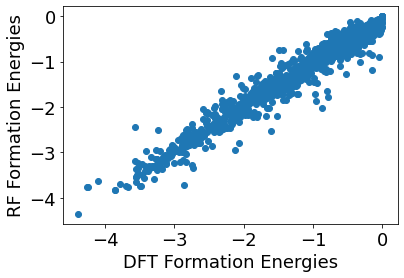

In [25]:
#Plot the true versus predicted values
plt.figure()

plt.scatter(list(y_test), predictions_list)
plt.xlabel('DFT Formation Energies')
plt.ylabel('RF Formation Energies')

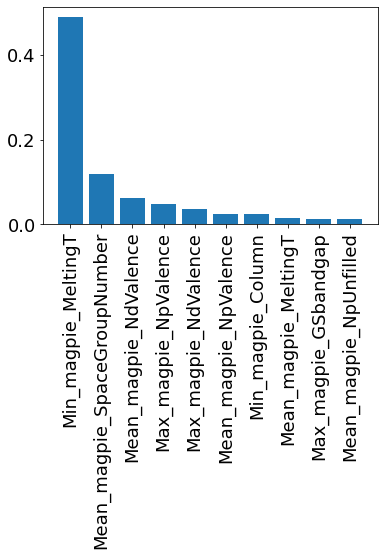

In [26]:
# Feature importance
f_names = np.array(magpie_names)
importances = best_regressor.feature_importances_
order = np.argsort(importances)[::-1]
numb_feats=10
plt.bar(np.arange(0,numb_feats),importances[order][0:numb_feats])
plt.xticks(np.arange(0,numb_feats),f_names[order][0:numb_feats],rotation=90)
f_names[order][0:numb_feats]
plt.rcParams.update({'font.size': 24})